In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shyam04","key":"582ff49b4ad1f02849d6a61200b3eac4"}'}

In [ ]:
import os
import zipfile

# Create Kaggle folder and move the JSON file there
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d kmader/pulmonary-chest-xray-abnormalities

Dataset URL: https://www.kaggle.com/datasets/kmader/pulmonary-chest-xray-abnormalities
License(s): unknown
yes
yes
yes
yes


In [ ]:
import zipfile

with zipfile.ZipFile("pulmonary-chest-xray-abnormalities.zip", 'r') as zip_ref:
    zip_ref.extractall("pulmonary_xray_data")


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from sklearn.utils import resample

# Load the demographic dataset
df = pd.read_excel("/content/updated_labels.xlsx")

# Check gender distribution
male_samples = df[df['Gender'] == 'male']
female_samples = df[df['Gender'] == 'female']
print(f"Original distribution - Male: {len(male_samples)}, Female: {len(female_samples)}")

# Define image transformations with standard augmentation
standard_augment_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),  # Slight rotation
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),  # Small translations
        scale=(0.95, 1.05),  # Slight scaling
        fill=0
    ),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define more aggressive augmentation for underrepresented group
aggressive_augment_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),  # More rotation
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # More translation
        scale=(0.9, 1.1),  # More scaling
        fill=0
    ),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally (anatomically plausible for X-rays)
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Slight brightness/contrast variation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Original image transform (for validation)
original_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom Dataset Class with gender-aware augmentation
class BalancedMultiModalDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None, augment_text=False,
                 gender_balance=False, female_transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform
        self.female_transform = female_transform  # Special transform for female samples
        self.augment_text = augment_text
        self.gender_balance = gender_balance

    def __len__(self):
        return len(self.dataframe)

    def augment_demographic(self, gender, age, is_female):
        """Apply augmentation to demographic data"""
        if not self.augment_text:
            return gender, age

        # Age augmentation (add small random noise to age)
        if is_female and self.gender_balance:
            # More varied age augmentation for female samples
            age_noise = random.uniform(-2, 3)  # Add +/- 3 years noise
        else:
            # Regular age augmentation
            age_noise = random.uniform(-1, 2)  # Add +/- 2 years noise

        augmented_age = max(1, age + age_noise)  # Ensure age stays positive

        return gender, augmented_age

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Load image
        image_path = os.path.join(self.image_folder, row['File'].replace('.txt', '.png'))
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Extract gender
        is_female = row["Gender"] == "female"
        gender = 0 if is_female else 1
        age = row["Age"]

        # Choose transform based on gender and settings
        if is_female and self.gender_balance and self.female_transform is not None:
            # Use special transform for female samples
            transform = self.female_transform
        else:
            transform = self.transform

        # Apply transform
        if transform:
            image = transform(image)

        # Apply text augmentation
        gender, age = self.augment_demographic(gender, age, is_female)

        text_features = torch.tensor([gender, age], dtype=torch.float32)
        label = torch.tensor(row["label"], dtype=torch.long)

        return image, text_features, label




# Create balanced data loaders
image_folder = "/content/pulmonary_xray_data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png"
train_loader, val_loader = create_balanced_data_loaders(df, image_folder, batch_size=32)

Original distribution - Male: 431, Female: 202
Training set - Male: 346, Female: 159
Exact counts after balancing - Male: 692, Female: 692
Total training samples: 1384


In [ ]:
def create_balanced_data_loaders(df, image_folder, batch_size=32):
    """Create data loaders with perfectly balanced gender representation"""

    # Split into train and validation (80/20)
    train_size = int(0.8 * len(df))
    val_size = len(df) - train_size
    indices = list(range(len(df)))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[:train_size], indices[train_size:]

    # Create train and validation dataframes
    train_df = df.iloc[train_indices].copy()
    val_df = df.iloc[val_indices].copy()

    # Check class distribution in training set
    male_train_df = train_df[train_df['Gender'] == 'male']
    female_train_df = train_df[train_df['Gender'] == 'female']
    male_count = len(male_train_df)
    female_count = len(female_train_df)
    print(f"Training set - Male: {male_count}, Female: {female_count}")
    # Create datasets for original data
    male_original_dataset = BalancedMultiModalDataset(
        male_train_df,
        image_folder,
        transform=original_image_transform,
        augment_text=False
    )
    female_original_dataset = BalancedMultiModalDataset(
        female_train_df,
        image_folder,
        transform=original_image_transform,
        augment_text=False
    )
    # Create datasets with standard augmentation
    male_standard_dataset = BalancedMultiModalDataset(
        male_train_df,
        image_folder,
        transform=standard_augment_transform,
        augment_text=True
    )
    female_standard_dataset = BalancedMultiModalDataset(
        female_train_df,
        image_folder,
        transform=standard_augment_transform,
        augment_text=True
    )

    # Calculate how many more female samples we need
    # Male: original + standard = 2*male_count
    # We need to match exactly this number
    target_female_count = 2 * male_count
    current_female_count = 2 * female_count  # original + standard augmentation
    additional_female_needed = target_female_count - current_female_count

    # No need to calculate factor - just directly create the exact number needed
    female_datasets = [female_original_dataset, female_standard_dataset]

    # Create aggressive augmentation datasets for females until we reach the target
    samples_to_generate = additional_female_needed
    while samples_to_generate > 0:
        # Either use all female samples or just what we need
        samples_this_round = min(samples_to_generate, female_count)

        # Random sample with replacement to avoid exact duplicates
        if samples_this_round < female_count:
            # Use random subset if we need fewer than all samples
            subset_indices = np.random.choice(female_count, samples_this_round, replace=False)
            subset_df = female_train_df.iloc[subset_indices].copy()
        else:
            # Use all samples
            subset_df = female_train_df.copy()

        # Create aggressive augmentation dataset
        aggressive_dataset = BalancedMultiModalDataset(
            subset_df,
            image_folder,
            transform=aggressive_augment_transform,
            augment_text=True,
            gender_balance=True
        )
        female_datasets.append(aggressive_dataset)
        samples_to_generate -= samples_this_round

    # Combine all datasets
    male_datasets = [male_original_dataset, male_standard_dataset]
    combined_train_dataset = ConcatDataset(male_datasets + female_datasets)

    # Validation dataset (no augmentation)
    val_dataset = BalancedMultiModalDataset(
        val_df,
        image_folder,
        transform=original_image_transform,
        augment_text=False
    )

    # Create data loaders
    train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Calculate exact gender distribution after augmentation
    male_after = male_count * 2  # Original + standard augmentation
    female_after = current_female_count + additional_female_needed

    print(f"Exact counts after balancing - Male: {male_after}, Female: {female_after}")
    print(f"Total training samples: {len(combined_train_dataset)}")
    assert male_after == female_after, "Balance was not achieved!"

    return train_loader, val_loader

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the multimodal model with ResNet18 backbone
class CNNMultimodalModel(nn.Module):
    def __init__(self, backbone_name='resnet18', text_feature_dim=2, hidden_dim=512, num_classes=2, dropout_rate=0.3):
        super().__init__()

        # Image encoder using ResNet18
        self.image_encoder = timm.create_model(backbone_name, pretrained=True, num_classes=0)

        # Get feature dimension from the backbone
        if backbone_name == 'resnet18':
            self.image_feature_dim = 512  # ResNet18 feature dimension
        elif 'mobilenetv2' in backbone_name:
            self.image_feature_dim = 1280  # MobileNetV2 feature dimension
        elif 'squeezenet' in backbone_name:
            self.image_feature_dim = 512  # SqueezeNet feature dimension
        elif 'shufflenet_v2' in backbone_name:
            self.image_feature_dim = 1024  # ShuffleNetV2 feature dimension
        else:
            # For other backbones, determine feature dim dynamically
            with torch.no_grad():
                dummy_input = torch.zeros(1, 3, 224, 224)
                dummy_output = self.image_encoder(dummy_input)
                self.image_feature_dim = dummy_output.shape[1]

        # Adapt first convolutional layer for grayscale images (1 channel)
        if 'resnet' in backbone_name:
            # For ResNet models
            orig_conv = self.image_encoder.conv1
            new_conv = nn.Conv2d(1, orig_conv.out_channels,
                                kernel_size=orig_conv.kernel_size,
                                stride=orig_conv.stride,
                                padding=orig_conv.padding,
                                bias=orig_conv.bias is not None)
            # Initialize with mean across RGB channels
            with torch.no_grad():
                if hasattr(orig_conv, 'weight'):
                    new_conv.weight[:, 0:1, :, :] = orig_conv.weight.mean(dim=1, keepdim=True)
            self.image_encoder.conv1 = new_conv
        elif 'mobilenet' in backbone_name:
            # For MobileNet models
            orig_conv = self.image_encoder.conv_stem
            new_conv = nn.Conv2d(1, orig_conv.out_channels,
                                kernel_size=orig_conv.kernel_size,
                                stride=orig_conv.stride,
                                padding=orig_conv.padding,
                                bias=orig_conv.bias is not None)
            # Initialize with mean across RGB channels
            with torch.no_grad():
                if hasattr(orig_conv, 'weight'):
                    new_conv.weight[:, 0:1, :, :] = orig_conv.weight.mean(dim=1, keepdim=True)
            self.image_encoder.conv_stem = new_conv

        # Text projection network with batch normalization
        self.text_projection = nn.Sequential(
            nn.Linear(text_feature_dim, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        # Image projection network with batch normalization
        self.image_projection = nn.Sequential(
            nn.Linear(self.image_feature_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )
        # Cross-modal attention
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=8,
            dropout=dropout_rate,
            batch_first=True
        )
        # Final classification layers with batch normalization
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, images, text_features):
        # Process images
        image_features = self.image_encoder(images)
        image_features = self.image_projection(image_features)

        # Process text features
        text_features = self.text_projection(text_features)

        # Reshape for attention if needed
        if len(image_features.shape) == 2:
            image_features = image_features.unsqueeze(1)  # [batch, 1, hidden_dim]
        if len(text_features.shape) == 2:
            text_features = text_features.unsqueeze(1)  # [batch, 1, hidden_dim]

        # Cross-modal attention
        # Using image as query, text as key/value
        attn_output, _ = self.cross_attn(
            query=image_features,
            key=text_features,
            value=text_features
        )

        # Combine features
        combined_features = torch.cat([
            image_features.squeeze(1),
            attn_output.squeeze(1)
        ], dim=1)

        # Classification
        output = self.classifier(combined_features)

        return output

Using device: cuda


In [ ]:
# Function to create data loaders with specific batch size
def create_data_loaders(batch_size=32):
    # Use the same datasets created earlier
    train_loader_new = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)
    val_loader_new = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader_new, val_loader_new


In [ ]:



# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, epochs=20, lr=5e-5, weight_decay=1e-4):
    model = model.to(device)

    # Check for class imbalance
    class_counts = torch.zeros(2)  # Assuming binary classification
    for _, _, labels in train_loader:
        for label in labels:
            class_counts[label] += 1

    # Calculate class weights if imbalanced
    if class_counts[0] != class_counts[1]:
        class_weights = class_counts.sum() / (2 * class_counts)
        class_weights = class_weights / class_weights.sum()
        print(f"Using class weights: {class_weights}")
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    else:
        criterion = nn.CrossEntropyLoss()

    # Optimizer with weight decay
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    best_val_accuracy = 0.0
    best_model_weights = None
    patience = 5  # Early stopping patience
    counter = 0

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, text_features, labels in train_loader:
            images = images.to(device)
            text_features = text_features.to(device)
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images, text_features)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Calculate training statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for images, text_features, labels in val_loader:
                images = images.to(device)
                text_features = text_features.to(device)
                labels = labels.to(device)

                outputs = model(images, text_features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())

        # Calculate metrics
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        # Update learning rate
        scheduler.step()

        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = model.state_dict().copy()
            counter = 0  # Reset early stopping counter
        else:
            counter += 1  # Increment counter if validation accuracy doesn't improve

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        print("-----")

        # Early stopping
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load best model for final evaluation
    model.load_state_dict(best_model_weights)
    return model, best_val_accuracy


In [ ]:
def evaluate_best_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    # Disable gradient calculation for inference
    with torch.no_grad():
        for images, text_features, labels in test_loader:
            images = images.to(device)
            text_features = text_features.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images, text_features)
            _, predicted = torch.max(outputs.data, 1)

            # Collect predictions and targets
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Convert to numpy arrays for sklearn metrics
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Create and plot confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Generate classification report
    cr = classification_report(all_targets, all_predictions)
    print("\nClassification Report:")
    print(cr)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return accuracy, cm, cr


In [ ]:

model = CNNMultimodalModel(
        backbone_name='resnet18',  # Using ResNet18 as CNN backbone
        text_feature_dim=2,  # gender and age
        hidden_dim=256,  # Reduced hidden dimension size
        num_classes=2,  # binary classification
        dropout_rate=0.3  # Increased dropout rate
    )

    # Train the model
trained_model, best_accuracy = train_and_evaluate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=20,
        lr=5e-5,  # Reduced learning rate
        weight_decay=1e-4  # Increased weight decay
    )

    # Save the trained model
torch.save(trained_model.state_dict(), 'best_resnet18_multimodal.pth')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Using class weights: tensor([0.4870, 0.5130])
Epoch 1/20
Train Loss: 0.6791, Train Acc: 0.5766
Val Loss: 0.5902, Val Acc: 0.6992
-----
Epoch 2/20
Train Loss: 0.5863, Train Acc: 0.6929
Val Loss: 0.5545, Val Acc: 0.7143
-----
Epoch 3/20
Train Loss: 0.5187, Train Acc: 0.7637
Val Loss: 0.3972, Val Acc: 0.8271
-----
Epoch 4/20
Train Loss: 0.4734, Train Acc: 0.7861
Val Loss: 0.3697, Val Acc: 0.8496
-----
Epoch 5/20
Train Loss: 0.4329, Train Acc: 0.8129
Val Loss: 0.3501, Val Acc: 0.8346
-----
Epoch 6/20
Train Loss: 0.4183, Train Acc: 0.8186
Val Loss: 0.3431, Val Acc: 0.8571
-----
Epoch 7/20
Train Loss: 0.3825, Train Acc: 0.8360
Val Loss: 0.3241, Val Acc: 0.8571
-----
Epoch 8/20
Train Loss: 0.3712, Train Acc: 0.8512
Val Loss: 0.3086, Val Acc: 0.8647
-----
Epoch 9/20
Train Loss: 0.3583, Train Acc: 0.8634
Val Loss: 0.3194, Val Acc: 0.8421
-----
Epoch 10/20
Train Loss: 0.3466, Train Acc: 0.8584
Val Loss: 0.3171, Val Acc: 0.8496
-----
Epoch 11/20
Train Loss: 0.3359, Train Acc: 0.8671
Val Loss: 0.2

In [ ]:
print(f"Model saved with best validation accuracy: {best_accuracy:.4f}")


Model saved with best validation accuracy: 0.8797



Evaluating best model...
Test Accuracy: 0.8722


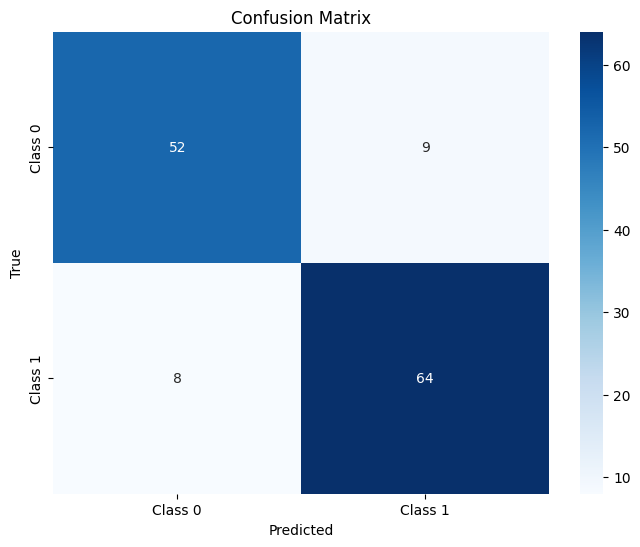


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        61
           1       0.88      0.89      0.88        72

    accuracy                           0.87       133
   macro avg       0.87      0.87      0.87       133
weighted avg       0.87      0.87      0.87       133

Precision: 0.8721
Recall: 0.8722
F1-Score: 0.8721
Model Evaluation Results

----------------------

Test Accuracy: 0.8722


Confusion Matrix:

[[52  9]
 [ 8 64]]




In [ ]:

    # Evaluate the model
print("\nEvaluating best model...")
accuracy, confusion_mat, class_report = evaluate_best_model(trained_model, val_loader, device)

    # Save evaluation metrics to file

print(f"Model Evaluation Results\n")
print(f"----------------------\n")
print(f"Test Accuracy: {accuracy:.4f}\n\n")
print("Confusion Matrix:\n")
print(str(confusion_mat) + "\n\n")




Input: Image=/content/pulmonary_xray_data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0002_0.png, Gender=male, Age=63
Prediction: Class 0
Probabilities: Class 0: 0.9852, Class 1: 0.0148


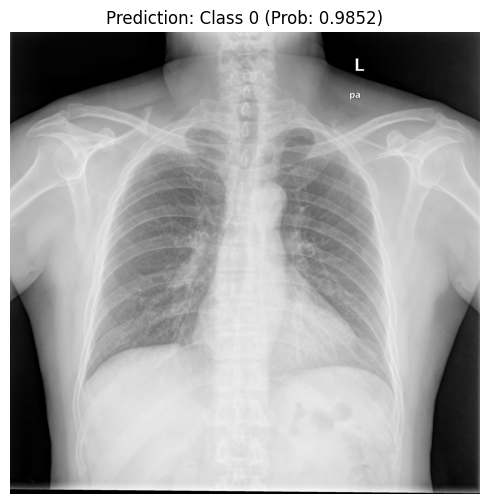

In [ ]:
def predict_single_image(model, image_path, gender, age, device, backbone_name='resnet18'):
    """
    Make a prediction on a single image with demographic information.

    Args:
        model: The trained model
        image_path: Path to the image file
        gender: 1 for male, 0 for female
        age: Age in years
        device: Device to run inference on ('cuda' or 'cpu')
        backbone_name: CNN backbone used in the model

    Returns:
        predicted_class: The predicted class (0 or 1)
        probabilities: The probability scores for each class
    """
    # Set model to evaluation mode
    model.eval()
    model = model.to(device)

    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Apply the same transforms as during validation
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Create text features tensor
    text_features = torch.tensor([[gender, age]], dtype=torch.float32).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor, text_features)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted_class = torch.max(outputs, 1)

    return predicted_class.item(), probabilities.cpu().numpy()[0]

# Example usage
def demo_single_prediction(model_path, image_path, gender, age, device=None):
    """
    Demo function to load a model and make a prediction on a single image.

    Args:
        model_path: Path to the saved model weights
        image_path: Path to the image file
        gender: String "male" or "female"
        age: Age in years
        device: Device to run inference on ('cuda' or 'cpu')

    Returns:
        None - prints the prediction results
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert gender string to numeric
    gender_numeric = 1 if gender.lower() == "male" else 0

    # Initialize the model with the same architecture as during training
    model = CNNMultimodalModel(
        backbone_name='resnet18',
        text_feature_dim=2,
        hidden_dim=256,
        num_classes=2,
        dropout_rate=0.3
    )

    # Load the trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Make prediction
    predicted_class, probabilities = predict_single_image(
        model=model,
        image_path=image_path,
        gender=gender_numeric,
        age=age,
        device=device
    )

    # Print results
    print(f"Input: Image={image_path}, Gender={gender}, Age={age}")
    print(f"Prediction: Class {predicted_class}")
    print(f"Probabilities: Class 0: {probabilities[0]:.4f}, Class 1: {probabilities[1]:.4f}")

    # Visualization (optional)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f"Prediction: Class {predicted_class} (Prob: {probabilities[predicted_class]:.4f})")
    plt.axis('off')
    plt.show()

    return predicted_class, probabilities


predicted_class, probs = demo_single_prediction(
     model_path='best_resnet18_multimodal.pth',
     image_path='/content/pulmonary_xray_data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0002_0.png',
     gender='male',
     age=63)


Generating GradCAM visualizations for validation samples...


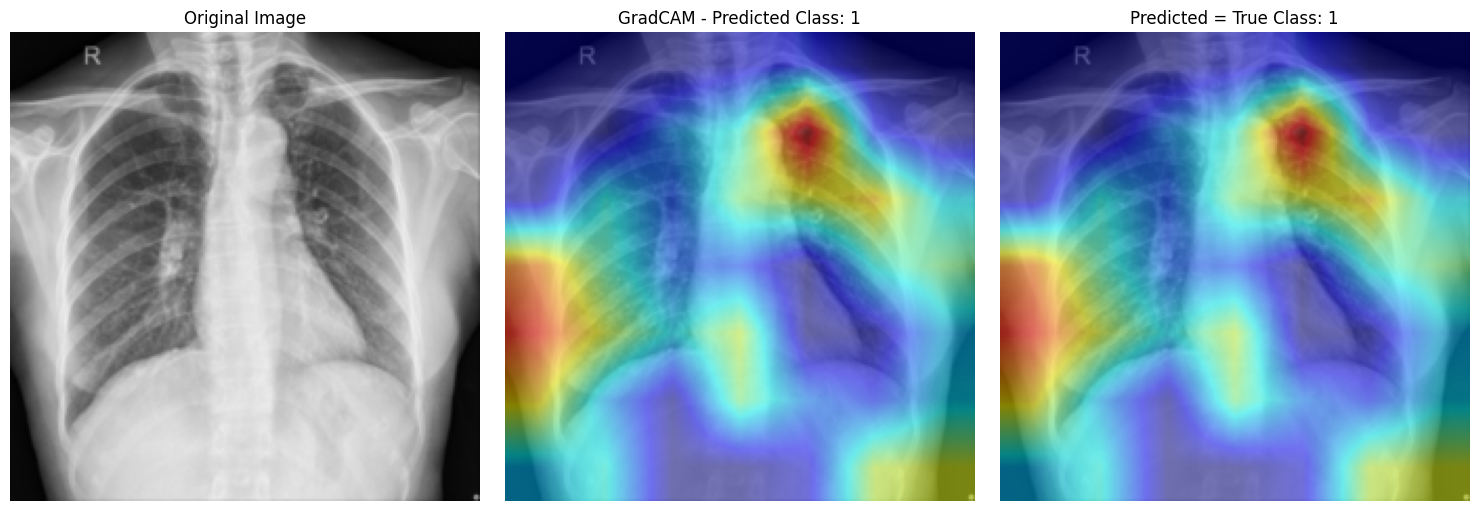

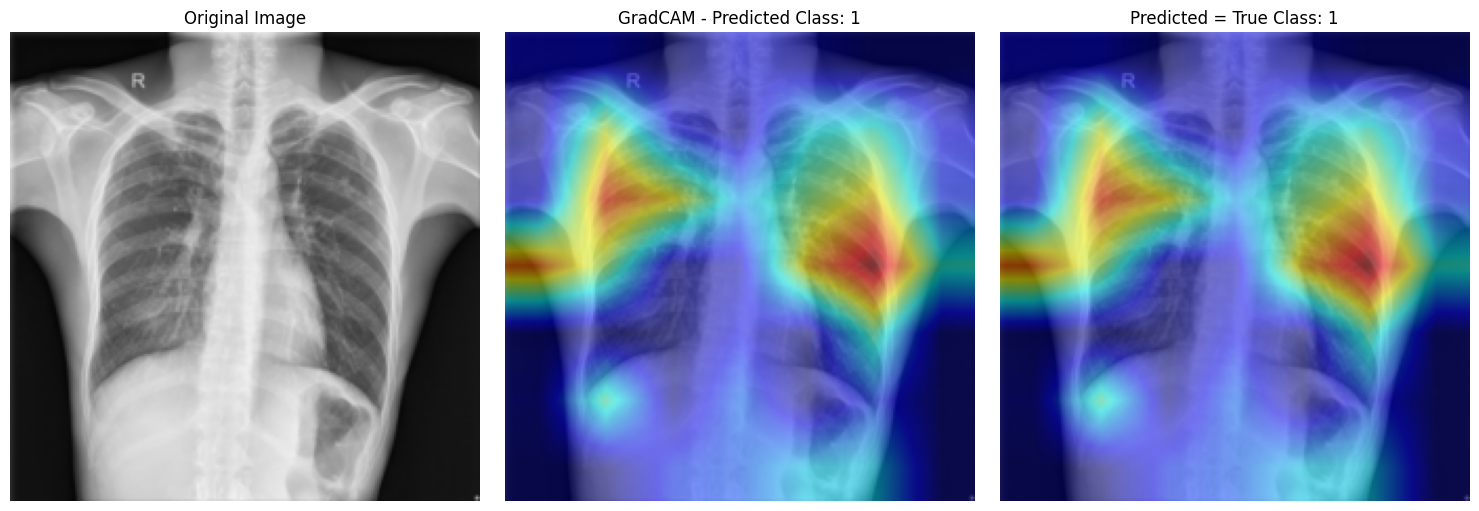

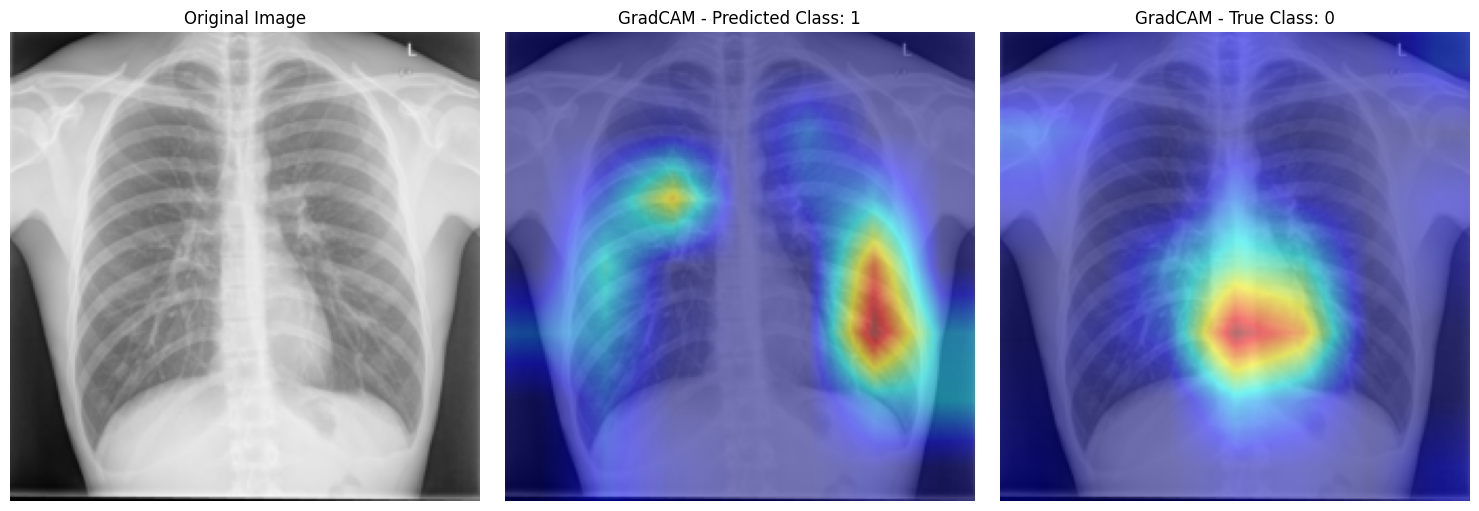

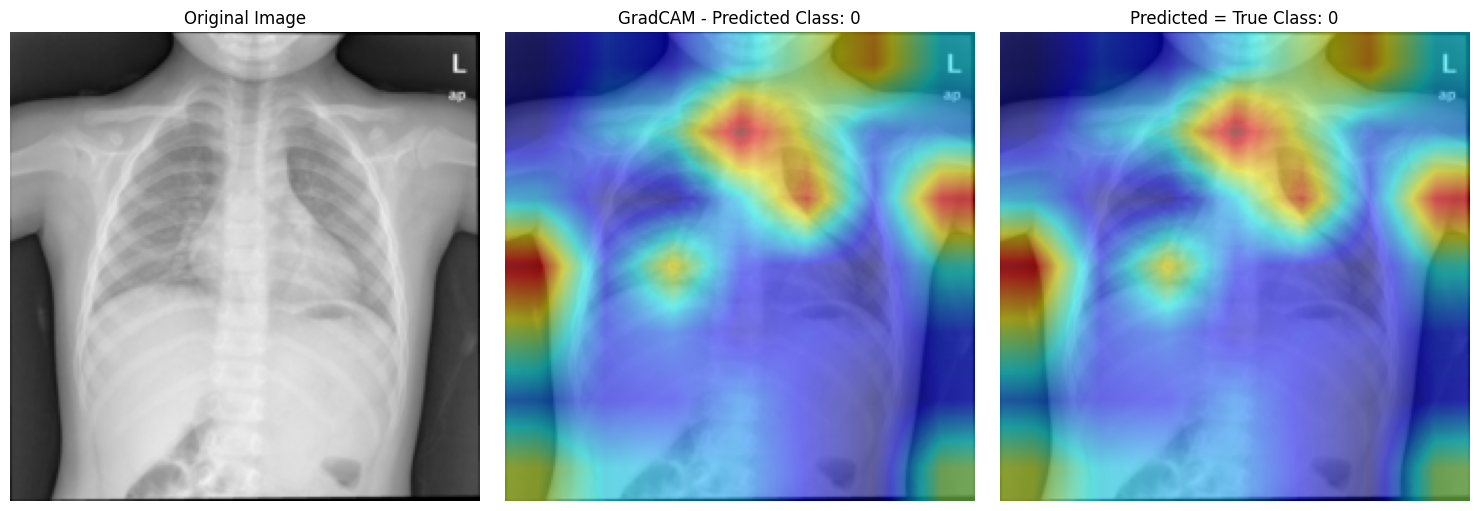

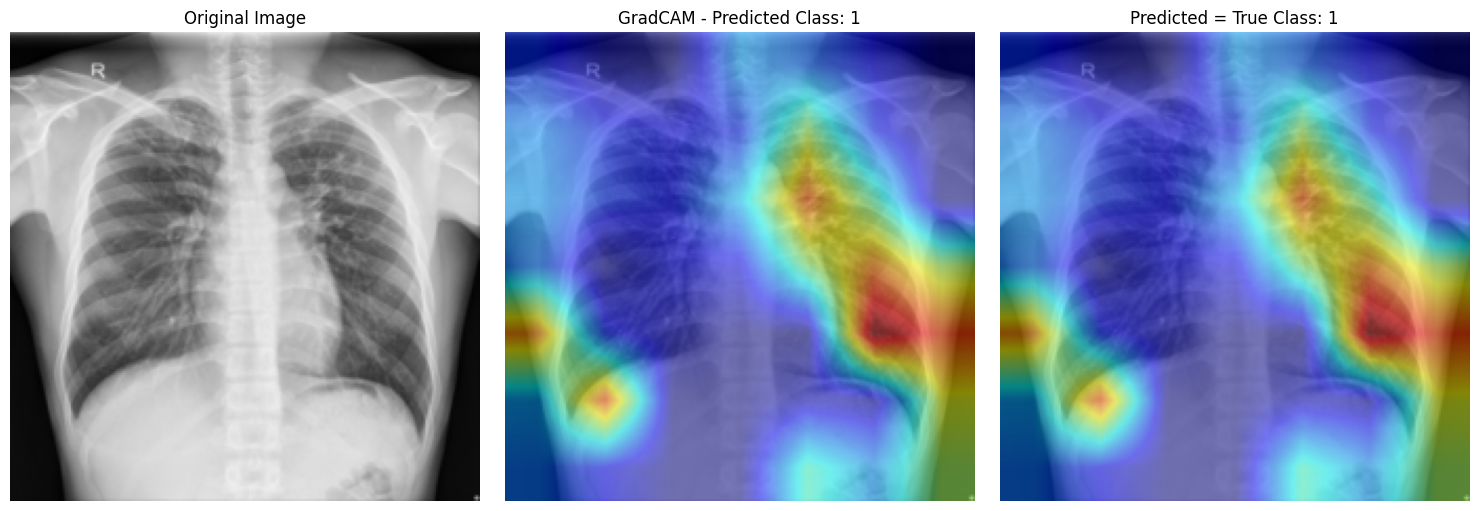

In [ ]:
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms


class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initializes GradCAM with a model and target layer

        Args:
            model (nn.Module): Trained model
            target_layer (nn.Module): Layer to extract gradients from
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Register hooks for the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def get_cam(self, class_idx=None):
        """
        Computes class activation map for the specified class

        Args:
            class_idx (int): Index of the class to generate CAM for.
                             If None, uses the class with highest score.

        Returns:
            Normalized CAM
        """
        # Get the gradient with respect to the target activation
        if self.gradients is None:
            return None

        # Global average pooling of the gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Weighted sum of activation maps
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)

        # Apply ReLU to focus on features that have a positive influence
        cam = F.relu(cam)

        # Normalize the CAM
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)

        return cam.detach().cpu().numpy()

    def __call__(self, images, text_features, class_idx=None):
        """
        Generates CAM for the specified input and class

        Args:
            images (torch.Tensor): Input images
            text_features (torch.Tensor): Text features
            class_idx (int): Target class index

        Returns:
            Class activation map
        """
        self.model.eval()
        self.model.zero_grad()

        # Forward pass
        outputs = self.model(images, text_features)

        # If class_idx is None, use the class with highest score
        if class_idx is None:
            class_idx = torch.argmax(outputs, dim=1).item()

        # Get the score for the target class
        target_score = outputs[0, class_idx]

        # Backward pass
        target_score.backward()

        # Generate the CAM
        cam = self.get_cam(class_idx)

        return cam, class_idx

# Function to visualize GradCAM
def visualize_gradcam(image, cam, alpha=0.5, cmap='jet'):
    """
    Visualizes GradCAM output overlaid on the original image

    Args:
        image (torch.Tensor): Original image tensor
        cam (numpy.ndarray): Class activation map
        alpha (float): Transparency of the heatmap

    Returns:
        Visualization of the GradCAM heatmap
    """
    # Convert the image tensor to numpy and denormalize
    img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = (img * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
    img = np.clip(img, 0, 1)

    # If image is grayscale, convert to RGB
    if img.shape[2] == 1:
        img = np.repeat(img, 3, axis=2)

    # Resize the CAM to match the image dimensions
    cam = cam.squeeze()
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap / 255.0

    # Overlay the heatmap on the image
    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    return img, heatmap, overlay

# Function to apply GradCAM to multiple images
def apply_gradcam_to_batch(model, data_loader, device, num_samples=5, target_layer=None):
    """
    Applies GradCAM to a batch of images

    Args:
        model (nn.Module): Trained model
        data_loader (DataLoader): Data loader for the dataset
        device (torch.device): Device to run the model on
        num_samples (int): Number of samples to visualize
        target_layer (nn.Module): Layer to extract gradients from (default: model's last conv layer)
    """
    model.to(device)
    model.eval()

    # If target layer is not specified, try to get the last convolutional layer
    if target_layer is None:
        # For ResNet18
        if hasattr(model, 'image_encoder') and hasattr(model.image_encoder, 'layer4'):
            target_layer = model.image_encoder.layer4[-1]
        else:
            print("Could not automatically determine the target layer. Please specify it.")
            return

    # Initialize GradCAM
    grad_cam = GradCAM(model, target_layer)

    # Get samples from the data loader
    samples = []
    count = 0
    for images, text_features, labels in data_loader:
        for i in range(min(len(images), num_samples - count)):
            samples.append((images[i:i+1], text_features[i:i+1], labels[i:i+1]))
            count += 1
        if count >= num_samples:
            break

    # Apply GradCAM to each sample
    for i, (image, text_features, label) in enumerate(samples):
        image = image.to(device)
        text_features = text_features.to(device)

        # Get model prediction
        with torch.no_grad():
            output = model(image, text_features)
            _, predicted = torch.max(output, 1)

        # Generate CAMs for both the predicted class and the actual class
        pred_class = predicted.item()
        true_class = label.item()

        # For predicted class
        cam_pred, _ = grad_cam(image, text_features, pred_class)

        # For actual class (if different from predicted)
        if pred_class != true_class:
            cam_true, _ = grad_cam(image, text_features, true_class)
        else:
            cam_true = cam_pred

        # Visualize the results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        img, _, _ = visualize_gradcam(image, np.zeros_like(cam_pred))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # GradCAM for predicted class
        _, _, overlay_pred = visualize_gradcam(image, cam_pred)
        axes[1].imshow(overlay_pred)
        axes[1].set_title(f'GradCAM - Predicted Class: {pred_class}')
        axes[1].axis('off')

        # GradCAM for true class (if different)
        if pred_class != true_class:
            _, _, overlay_true = visualize_gradcam(image, cam_true)
            axes[2].imshow(overlay_true)
            axes[2].set_title(f'GradCAM - True Class: {true_class}')
        else:
            axes[2].imshow(overlay_pred)
            axes[2].set_title(f'Predicted = True Class: {true_class}')
        axes[2].axis('off')

        plt.tight_layout()
        plt.savefig(f'gradcam_sample_{i}.png')
        plt.show()

# Load the trained model
def load_model_for_gradcam(model_path):
    """
    Loads the trained model for GradCAM visualization

    Args:
        model_path (str): Path to the trained model weights

    Returns:
        The loaded model
    """
    # Initialize the model with the same architecture
    model = CNNMultimodalModel(
        backbone_name='resnet18',
        text_feature_dim=2,
        hidden_dim=256,
        num_classes=2,
        dropout_rate=0.3
    )

    # Load the trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    return model

# Function to run GradCAM on a single example
def run_gradcam_on_example(model, image_path, gender, age, target_class=None):
    """
    Runs GradCAM on a single example

    Args:
        model (nn.Module): Trained model
        image_path (str): Path to the image file
        gender (int): Gender (0 for female, 1 for male)
        age (float): Age value
        target_class (int): Target class for GradCAM (None for predicted class)
    """
    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    transform = original_image_transform
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Create text features tensor
    text_features = torch.tensor([[gender, age]], dtype=torch.float32).to(device)

    # Get the target layer for GradCAM
    target_layer = model.image_encoder.layer4[-1]

    # Initialize GradCAM
    grad_cam = GradCAM(model, target_layer)

    # Get model prediction
    with torch.no_grad():
        output = model(image_tensor, text_features)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    # Use the predicted class if target_class is not specified
    if target_class is None:
        target_class = predicted.item()

    # Generate CAM
    cam, _ = grad_cam(image_tensor, text_features, target_class)

    # Visualize the results
    img, heatmap, overlay = visualize_gradcam(image_tensor, cam)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(heatmap)
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')

    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay (Class {target_class}, Conf: {confidence.item():.2f})')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig('gradcam_single_example.png')
    plt.show()

    # Print additional information
    print(f"Gender: {'Male' if gender == 1 else 'Female'}, Age: {age:.1f}")
    print(f"Predicted class: {predicted.item()} with confidence: {confidence.item():.4f}")
    print(f"Class probabilities: {probabilities[0].cpu().numpy()}")

# Example usage
if __name__ == "__main__":
    # 1. Load your trained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = 'best_resnet18_multimodal.pth'
    model = load_model_for_gradcam(model_path)

    # 2. Apply GradCAM to multiple samples from validation set
    print("Generating GradCAM visualizations for validation samples...")
    apply_gradcam_to_batch(model, val_loader, device, num_samples=5)

    # 3. Or apply GradCAM to a specific example
    # Uncomment and modify the path and demographic info as needed
    """
    image_path = "/content/pulmonary_xray_data/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/example.png"
    gender = 1  # 1 for male, 0 for female
    age = 45.0
    run_gradcam_on_example(model, image_path, gender, age)
    """

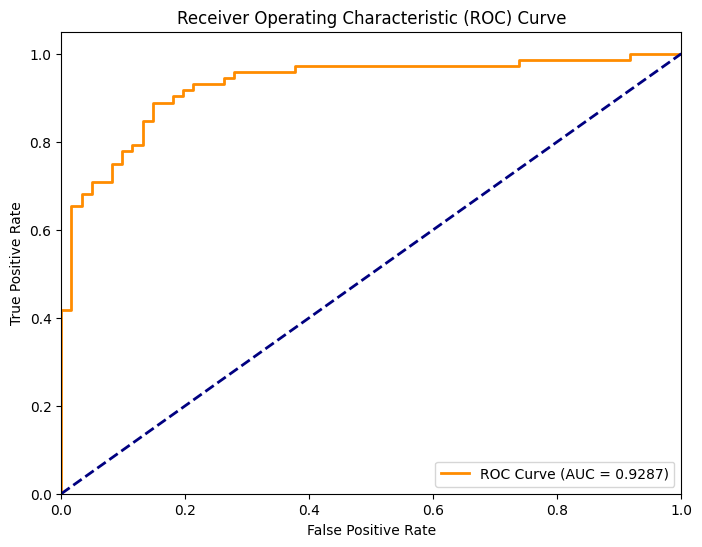

ROC AUC Score: 0.9287


In [ ]:
from sklearn.metrics import roc_curve, auc

# Collect prediction probabilities for ROC curve
trained_model.eval()
all_probs = []
all_targets = []

with torch.no_grad():
    for images, text_features, labels in val_loader:
        images = images.to(device)
        text_features = text_features.to(device)
        labels = labels.to(device)

        outputs = trained_model(images, text_features)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")
